In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from functions import compile_results

In [4]:
all_results = compile_results('preprocessing_comparison')

,model,train_seed,accuracy,macro_f1,weighted_f1,neutral_f1,positive_f1,negative_f1
0,allegro/herbert-base-cased,12.0,0.734569,0.674289,0.729294,0.667942,0.806562,0.548364
1,dkleczek/bert-base-polish-cased-v1,12.0,0.718034,0.657654,0.716133,0.617981,0.802604,0.552376
2,google-bert/bert-base-multilingual-cased,12.0,0.637514,0.512654,0.614415,0.427081,0.767106,0.343775
3,sdadas/polish-roberta-base-v2,12.0,0.746337,0.692917,0.743596,0.690244,0.814337,0.574170


e:\Project_clean\PolishTweetsClassification\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
e:\Project_clean\PolishTweetsClassification\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
e:\Project_clean\PolishTweetsClassification\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

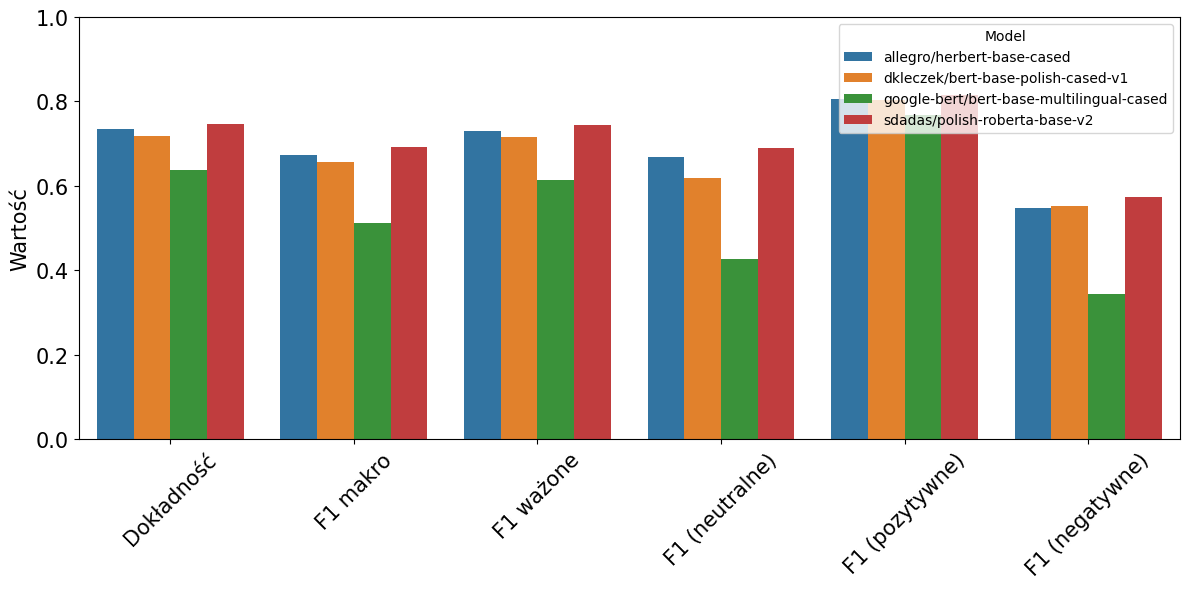

In [8]:
cols_to_use = all_results.select_dtypes(include='number').columns.drop('model_seed')
model_comparison = all_results.groupby(['model'])[cols_to_use].agg('mean').reset_index()
display(model_comparison)
metrics = ['accuracy', 'macro_f1', 'weighted_f1', 'neutral_f1', 'positive_f1', 'negative_f1']
df_melted = model_comparison.melt(id_vars=['model'], value_vars=metrics,
                    var_name='metric', value_name='value')
metric_translation = {
    'accuracy': 'Dokładność',
    'macro_f1': 'F1 makro',
    'weighted_f1': 'F1 ważone',
    'neutral_f1': 'F1 (neutralne)',
    'positive_f1': 'F1 (pozytywne)',
    'negative_f1': 'F1 (negatywne)'
}
df_melted['metric_pl'] = df_melted['metric'].map(metric_translation)
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='metric_pl', y='value', hue='model')
plt.title("")
plt.xticks(rotation=45, fontsize=15)
plt.ylabel("Wartość", fontsize=15)
plt.legend(title='Model', loc='upper right')
plt.yticks(fontsize=15)
plt.ylim(0, 1)
plt.xlabel("")
plt.tight_layout()
plt.show()

C:\Users\szymo\AppData\Local\Temp\ipykernel_14288\3489151217.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.loc[:,'dataset'].replace(to_replace=zmiana_nazw, inplace = True)
e:\Project_clean\PolishTweetsClassification\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
e:\Project_clean

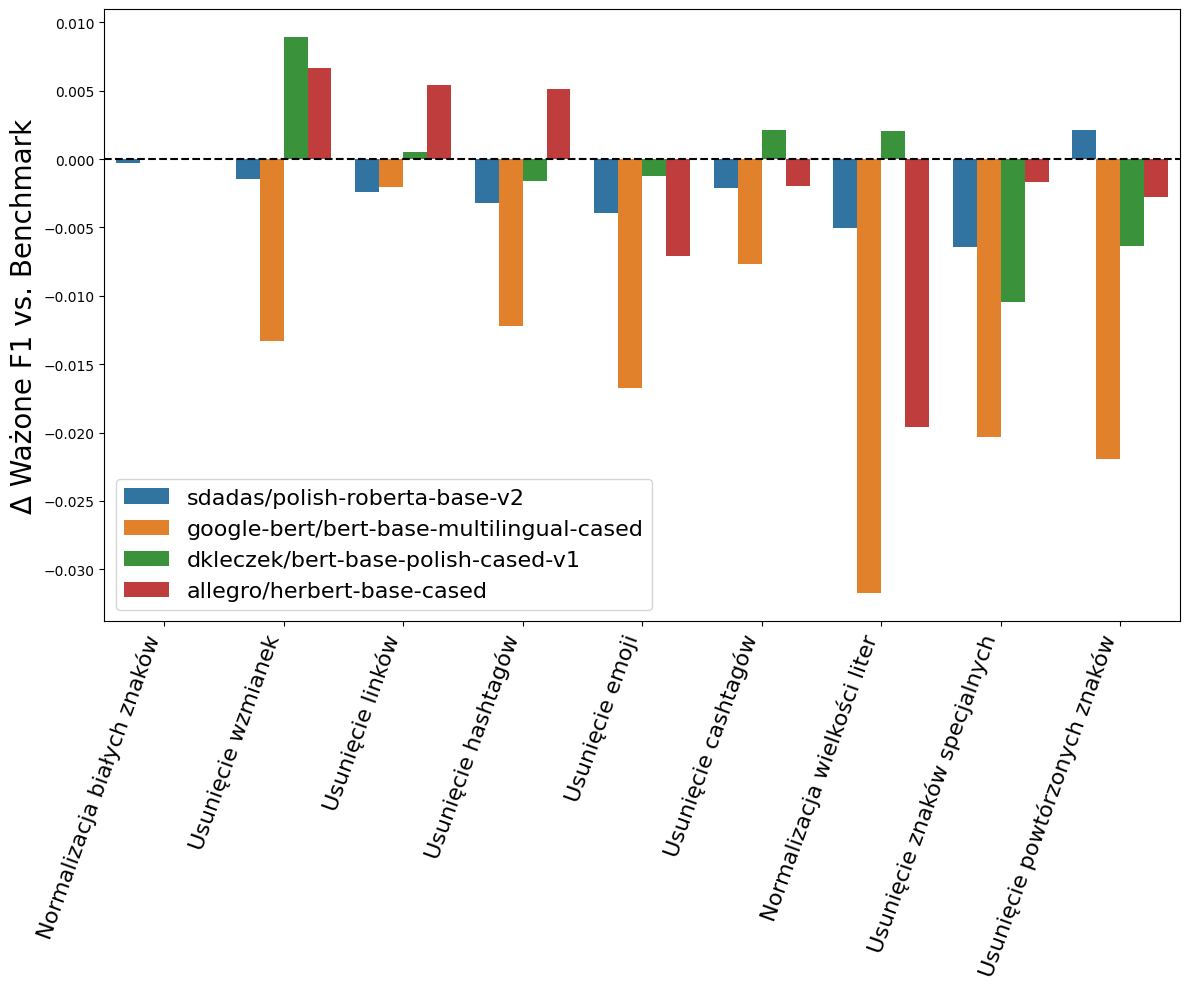

In [9]:
cols_to_use = all_results.select_dtypes(include='number').columns.drop('model_seed')
pre_processing = all_results.groupby(['dataset', 'model'])['weighted_f1'].agg('mean').reset_index().sort_values(by = ['model','dataset','weighted_f1'], ascending = False)
benchmark = pre_processing.loc[pre_processing['dataset']=='No_processing',['model','weighted_f1']]

df = pd.merge(pre_processing, benchmark, on='model', suffixes=('', '_benchmark'))
df['dataset'].unique().tolist()
zmiana_nazw  = {'No_processing_norm': 'Normalizacja białych znaków',
 'No_processing_mention' : 'Usunięcie wzmianek',
 'No_processing_http': 'Usunięcie linków',
 'No_processing_hashtag': 'Usunięcie hashtagów',
 'No_processing_emoji': 'Usunięcie emoji',
 'No_processing_cashtag': 'Usunięcie cashtagów',
 'No_processing_caps': 'Normalizacja wielkości liter',
 'No_processing__text': 'Usunięcie znaków specjalnych',
 'No_processing__rep': 'Usunięcie powtórzonych znaków', 
 'No_processing': 'Brak przetwarzania'}

df.loc[:,'dataset'].replace(to_replace=zmiana_nazw, inplace = True)


baseline = df[df['dataset'] == 'Brak przetwarzania'][['model', 'weighted_f1']]
baseline = baseline.rename(columns={'weighted_f1': 'baseline_f1'})

# Merge baseline back to the full dataset
df = df.merge(baseline, on='model')

# Calculate the difference
df['delta'] = df['weighted_f1'] - df['baseline_f1']

# Filter out the baseline itself (we don't need to compare it to itself)
df_filtered = df[df['dataset'] != 'Brak przetwarzania']

# Plot the delta
plt.figure(figsize=(12, 10))
sns.barplot(data=df_filtered, x='dataset', y='delta', hue='model')
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=70, ha='right', fontsize=16)
#plt.title("Zmiana w ważonym F1 w porównianiu do Benchmark (No_processing) dla różnych modeli")
plt.ylabel("Δ Ważone F1 vs. Benchmark", fontsize=20)
plt.xlabel("", fontsize=20)

plt.legend(prop={'size': 16})

plt.tight_layout()
plt.show()

C:\Users\szymo\AppData\Local\Temp\ipykernel_14288\572742276.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.loc[:,'dataset'].replace(to_replace=zmiana_nazw, inplace = True)
e:\Project_clean\PolishTweetsClassification\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


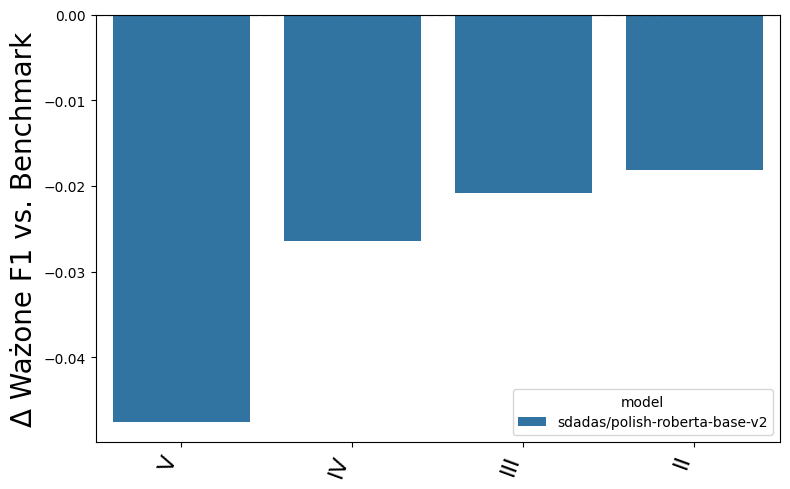

In [10]:
all_results = compile_results('strategy_comparison')
cols_to_use = all_results.select_dtypes(include='number').columns
pre_processing = all_results.groupby(['dataset', 'model'])['weighted_f1'].agg('mean').reset_index().sort_values(by = ['model','dataset','weighted_f1'], ascending = False)
df = pre_processing
baseline = df[df['dataset'] == 'Basic_processing'][['model', 'weighted_f1']]
baseline = baseline.rename(columns={'weighted_f1': 'baseline_f1'})

zmiana_nazw  = {'Basic_processing': 'I',
 'Basic_processing_spelling': 'II',
 'Basic_processing_spelling_SP': 'III',
 'Basic_processing_spelling_lem': 'IV',
 'Basic_processing_spelling_lem_SP': 'V'
}

# zmiana_nazw  = {'Basic_processing': 'Podst. przetw.',
#  'Basic_processing_spelling': 'Podst. przetw. z korektą ',
#  'Basic_processing_spelling_SP': 'Podst. przetw. z korektą  i usuwaniem wyrazów stopu',
#  'Basic_processing_spelling_lem': 'Podst. przetw. z korektą  i lematyzacją',
#  'Basic_processing_spelling_lem_SP': 'Podst. przetw. z korektą, lematyzacją i bez stop words'
# }

df.loc[:,'dataset'].replace(to_replace=zmiana_nazw, inplace = True)

# Merge baseline back to the full dataset
df = df.merge(baseline, on='model')

# Calculate the difference
df['delta'] = df['weighted_f1'] - df['baseline_f1']

# Filter out the baseline itself (we don't need to compare it to itself)
df_filtered = df[df['dataset'] != 'I']

# Plot the delta
plt.figure(figsize=(8, 5))
sns.barplot(data=df_filtered, x='dataset', y='delta', hue='model')
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=70, ha='right', fontsize=16)
plt.ylabel("Δ Ważone F1 vs. Benchmark", fontsize=20)
plt.xlabel("", fontsize=20)

plt.tight_layout()
plt.show()

In [5]:
all_results = compile_results('grid_search_comparison')

In [6]:
all_results.sort_values(by=['weighted_f1'], ascending=False, inplace=True)
all_results.head(15).to_clipboard()

SyntaxError: unterminated string literal (detected at line 64) (1307326464.py, line 64)

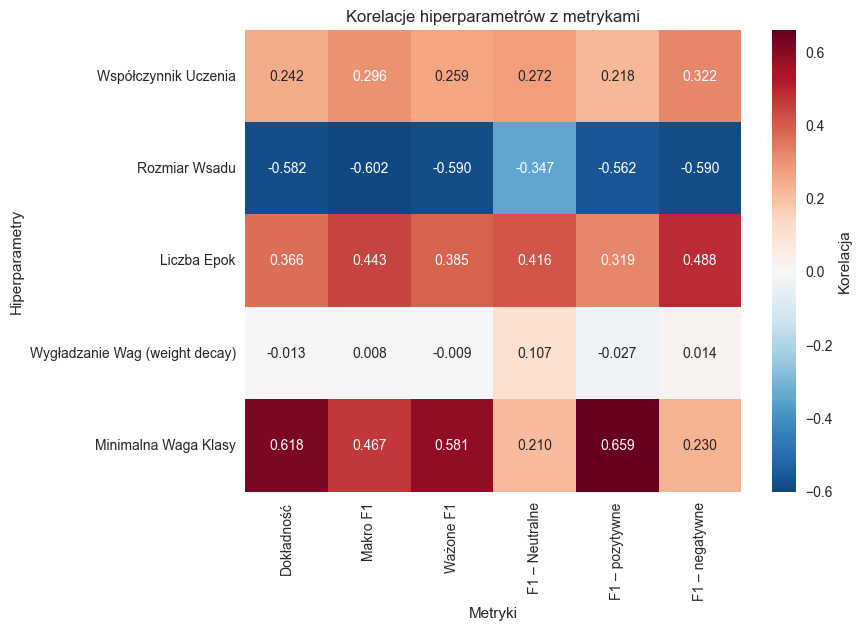

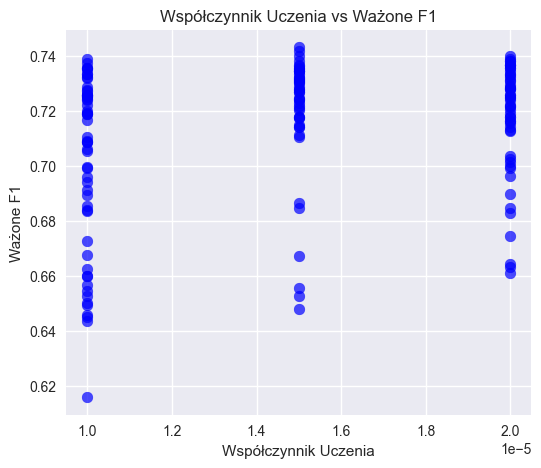

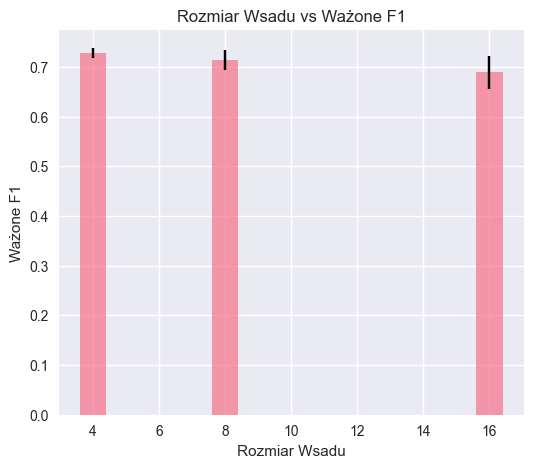

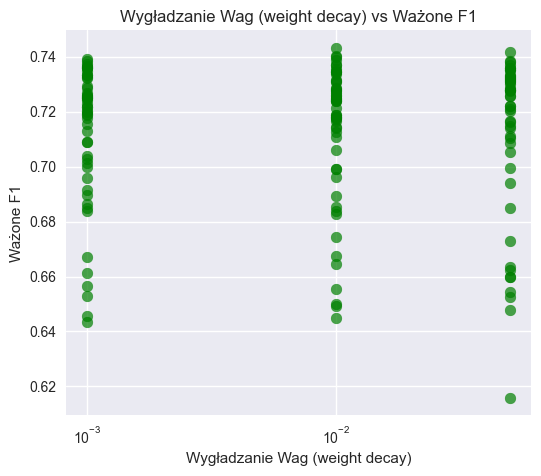

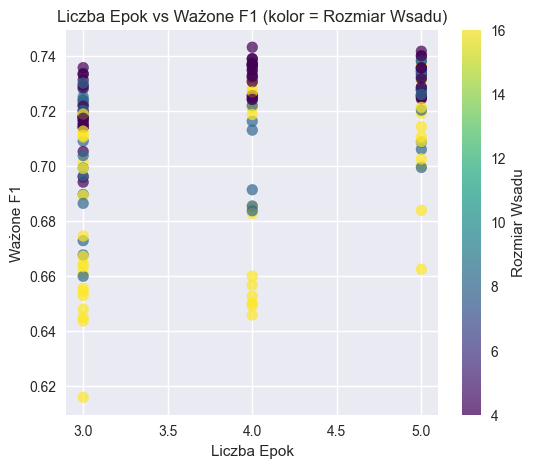

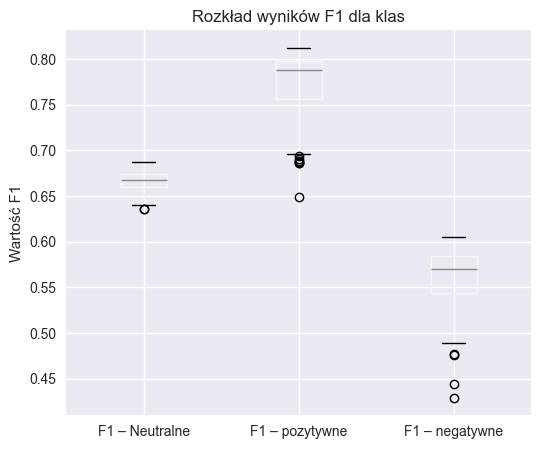

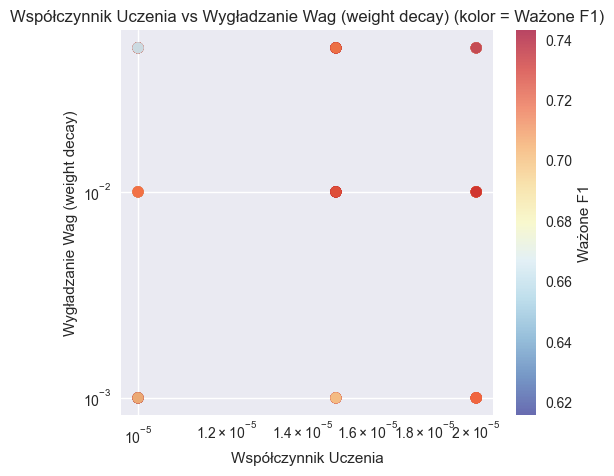

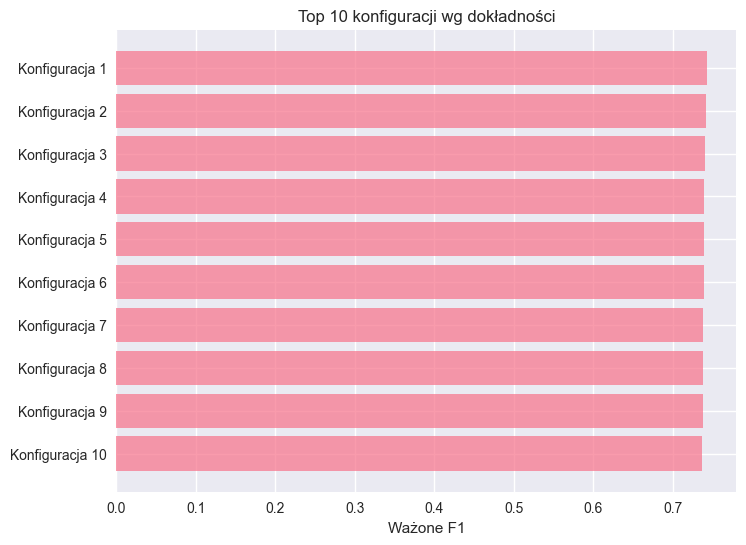

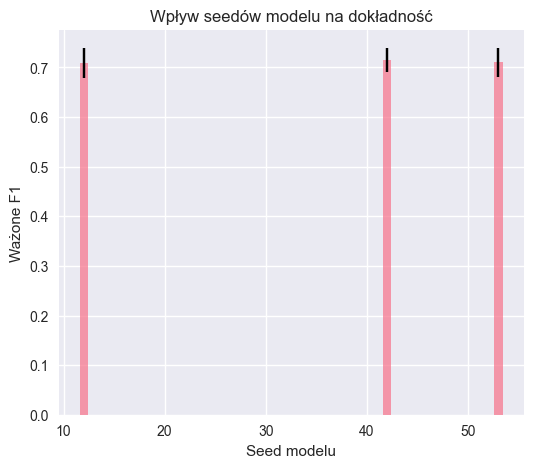

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Dane

df = all_results

# Słownik tłumaczeń nazw
nazwy_polskie = {
    'learning_rate': 'Współczynnik Uczenia',
    'batch_size': 'Rozmiar Wsadu',
    'epochs': 'Liczba Epok',
    'weight_decay': 'Wygładzanie Wag (weight decay)',
    'class_weight_floor': 'Minimalna Waga Klasy',
    'accuracy': 'Dokładność',
    'macro_f1': 'Makro F1',
    'weighted_f1': 'Ważone F1',
    'neutral_f1': 'F1 – Neutralne',
    'positive_f1': 'F1 – pozytywne',
    'negative_f1': 'F1 – negatywne',
}

metrics = ['accuracy', 'macro_f1', 'weighted_f1', 'neutral_f1', 'positive_f1', 'negative_f1']
hyperparams = ['learning_rate', 'batch_size', 'epochs', 'weight_decay', 'class_weight_floor']

# 1. Korelacje
plt.figure(figsize=(8, 6))
corr = df[hyperparams + metrics].corr().loc[hyperparams, metrics]
corr.index = [nazwy_polskie[c] for c in corr.index]
corr.columns = [nazwy_polskie[c] for c in corr.columns]
sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, fmt='.3f', cbar_kws={'label': 'Korelacja'})
plt.title('Korelacje hiperparametrów z metrykami')
plt.xlabel('Metryki')
plt.ylabel('Hiperparametry')
plt.show()

# 2. Współczynnik uczenia vs Dokładność
plt.figure(figsize=(6, 5))
plt.scatter(df['learning_rate'], df['weighted_f1'], alpha=0.7, s=60, c='blue')
plt.xlabel(nazwy_polskie['learning_rate'])
plt.ylabel(nazwy_polskie['weighted_f1'])
plt.title(f"{nazwy_polskie['learning_rate']} vs {nazwy_polskie['weighted_f1']}")
plt.ticklabel_format(style='scientific', axis='x', scilimits=(0, 0))
plt.show()

# 3. Rozmiar partii vs weighted_f1
plt.figure(figsize=(6, 5))
unq = df['batch_size'].unique()
means = [df[df['batch_size'] == b]['weighted_f1'].mean() for b in unq]
stds = [df[df['batch_size'] == b]['weighted_f1'].std() for b in unq]
plt.bar(unq, means, yerr=stds, alpha=0.7, capsize=5)
plt.xlabel(nazwy_polskie['batch_size'])
plt.ylabel(nazwy_polskie['weighted_f1'])
plt.title(f"{nazwy_polskie['batch_size']} vs {nazwy_polskie['weighted_f1']}")
plt.show()

# 4. Wygładzanie wag vs Weighted F1
plt.figure(figsize=(6, 5))
plt.scatter(df['weight_decay'], df['weighted_f1'], alpha=0.7, s=60, c='green')
plt.xlabel(nazwy_polskie['weight_decay'])
plt.ylabel(nazwy_polskie['weighted_f1'])
plt.title(f"{nazwy_polskie['weight_decay']} vs {nazwy_polskie['weighted_f1']}")
plt.xscale('log')
plt.show()

# 5. Liczba epok vs Dokładność (kolor = batch size)
plt.figure(figsize=(6, 5))
scatter = plt.scatter(df['epochs'], df['weighted_f1'], c=df['batch_size'], cmap='viridis', s=60, alpha=0.7)
plt.colorbar(scatter, label=nazwy_polskie['batch_size'])
plt.xlabel(nazwy_polskie['epochs'])
plt.ylabel(nazwy_polskie['weighted_f1'])
plt.title(f"{nazwy_polskie['epochs']} vs {nazwy_polskie['weighted_f1']} (kolor = {nazwy_polskie['batch_size']})")
plt.show()

# 6. Rozkład F1 dla klas
plt.figure(figsize=(6, 5))
f1_cols = ['neutral_f1', 'positive_f1', 'negative_f1']
df[[*f1_cols]].rename(columns=nazwy_polskie).boxplot()
plt.ylabel('Wartość F1')
plt.title('Rozkład wyników F1 dla klas')
plt.show()

# 7. Learning rate vs weight decay (kolor = dokładność)
plt.figure(figsize=(6, 5))
scatter = plt.scatter(df['learning_rate'], df['weight_decay'], c=df['weighted_f1'], cmap='RdYlBu_r', s=60, alpha=0.7)
plt.colorbar(scatter, label=nazwy_polskie['weighted_f1'])
plt.xlabel(nazwy_polskie['learning_rate'])
plt.ylabel(nazwy_polskie['weight_decay'])
plt.title(f"{nazwy_polskie['learning_rate']} vs {nazwy_polskie['weight_decay']} (kolor = {nazwy_polskie['weighted_f1']})")
plt.xscale('log')
plt.yscale('log')
plt.show()

# 8. Top 10 konfiguracji wg dokładności
plt.figure(figsize=(8, 6))
top_10 = df.sort_values('weighted_f1', ascending=False).head(10)
plt.barh(range(len(top_10)), top_10['weighted_f1'], alpha=0.7)
plt.yticks(range(len(top_10)), [f'Konfiguracja {i+1}' for i in range(len(top_10))])
plt.xlabel(nazwy_polskie['weighted_f1'])
plt.title('Top 10 konfiguracji wg dokładności')
plt.gca().invert_yaxis()
plt.show()

# 9. Wpływ seedów modelu na dokładność
plt.figure(figsize=(6, 5))
seed_stats = df.groupby('model_seed')['weighted_f1'].agg(['mean', 'std'])
plt.bar(seed_stats.index, seed_stats['mean'], yerr=seed_stats['std'], alpha=0.7, capsize=5)
plt.xlabel('Seed modelu')
plt.ylabel(nazwy_polskie['weighted_f1'])
plt.title('Wpływ seedów modelu na dokładność')
plt.show()


e:\Project_clean\PolishTweetsClassification\.venv\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


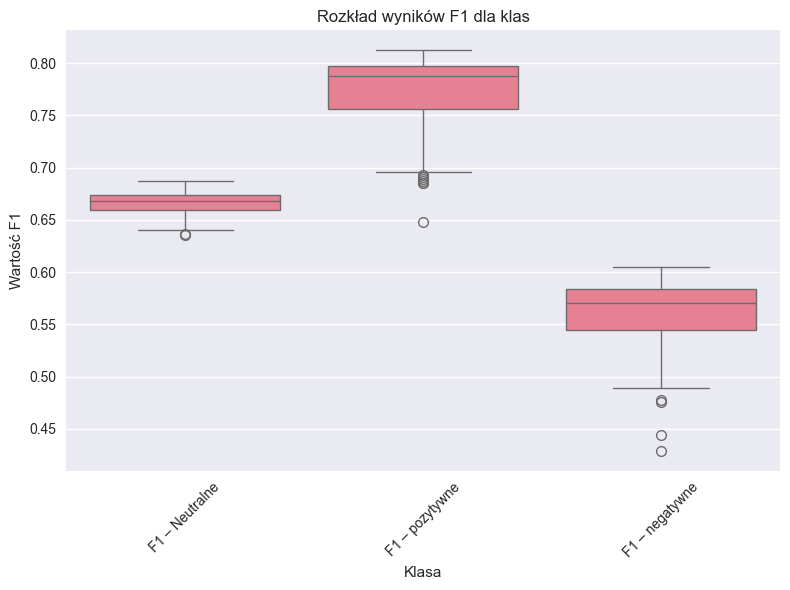

In [15]:
plt.figure(figsize=(8, 6))
df_melted = df[f1_cols].rename(columns=nazwy_polskie).melt(
    var_name='Klasa', value_name='Wartość F1'
)
sns.boxplot(data=df_melted, x='Klasa', y='Wartość F1')
plt.title('Rozkład wyników F1 dla klas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

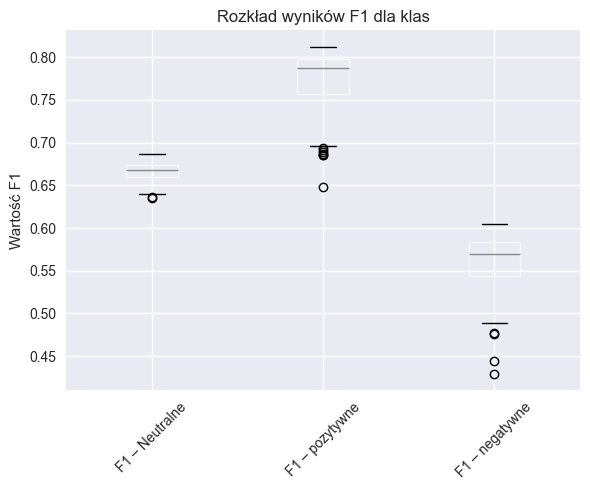

In [13]:
plt.figure(figsize=(6, 5))
f1_cols = ['neutral_f1', 'positive_f1', 'negative_f1']
df[f1_cols].rename(columns=nazwy_polskie).boxplot()
plt.ylabel('Wartość F1')
plt.title('Rozkład wyników F1 dla klas')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()  # Prevents label cutoff
plt.show()

In [9]:
#STOCK DATA PROCESSING
companies_stock_data = {}
companies =  list(all_data['stock_company'].unique())

for company in companies:
    df = pd.read_csv(f'Stock_data/{company}.csv')
    df['Data'] = pd.to_datetime(df['Data'])
    df.sort_values(by = 'Data')

    # Calculate returns and other metrics
    df['Return'] = df['Zamkniecie'].pct_change()
    df['Same_day_return'] = (df['Zamkniecie'] - df['Otwarcie'])/ df['Otwarcie']
    df['Overnight_return'] = (df['Zamkniecie'] - df['Otwarcie'].shift(1))/ df['Zamkniecie']
    df['Change'] = df['Zamkniecie'] - df['Zamkniecie'].shift(1)

    df['Direction'] = df['Return'].apply(lambda x: 1 if x >0 else -1 )
    

    df['volatility'] = (
    (df['Najwyzszy'] - df['Najnizszy']) / df['Otwarcie']
    ).where(df['Otwarcie'] != 0, 0)

    
    # Create a complete date range from the minimum to maximum date in the dataset
    date_range = pd.date_range(start=df['Data'].min(), 
                          end=df['Data'].max(), 
                          freq='D')  
    
    # Reindex with complete date range
    df = df.set_index('Data').reindex(date_range).reset_index()
    df = df.rename(columns={'index': 'Date'})
    df['Date'] = pd.to_datetime(df['Date'], errors='raise')
    df['weekday'] = df['Date'].dt.day_name()
    df['company'] = company
    df['is_trading_day'] = df['Zamkniecie'].notna()
    companies_stock_data[company] = df



In [13]:
df_raw = pd.read_csv(r'TrainingData\FINAL_TWEET_DATA.csv')
df_raw.drop('Unnamed: 0',axis=1,inplace = True)
df_raw = df_raw.drop_duplicates()
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63954 entries, 0 to 63953
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  63954 non-null  int64  
 1   created_at          63954 non-null  object 
 2   user_name           63953 non-null  object 
 3   user_id             63954 non-null  int64  
 4   text                63954 non-null  object 
 5   lang                63954 non-null  object 
 6   in_reply_to         38247 non-null  float64
 7   is_quote_status     63954 non-null  int64  
 8   quote_id            2402 non-null   float64
 9   retweeted_tweet_id  0 non-null      float64
 10  possibly_sensitive  17790 non-null  float64
 11  quote_count         63954 non-null  int64  
 12  reply_count         63954 non-null  int64  
 13  favorite_count      63954 non-null  int64  
 14  retweet_count       63954 non-null  int64  
 15  view_count          63909 non-null  float64
 16  hash

In [16]:
df_raw['id'].count()

63954

In [15]:
df_cleaned = pd.read_csv(r'TrainingData\FINAL_TWEET_DATA_CLEANED.csv')
df_cleaned = df_cleaned.drop_duplicates()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55809 entries, 0 to 55808
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  55809 non-null  int64  
 1   created_at          55809 non-null  object 
 2   user_name           55808 non-null  object 
 3   user_id             55809 non-null  int64  
 4   text                55809 non-null  object 
 5   lang                55809 non-null  object 
 6   in_reply_to         35801 non-null  float64
 7   is_quote_status     55809 non-null  int64  
 8   quote_id            2250 non-null   float64
 9   retweeted_tweet_id  0 non-null      float64
 10  possibly_sensitive  12808 non-null  float64
 11  quote_count         55809 non-null  int64  
 12  reply_count         55809 non-null  int64  
 13  favorite_count      55809 non-null  int64  
 14  retweet_count       55809 non-null  int64  
 15  view_count          55764 non-null  float64
 16  hash

In [17]:
df_cleaned['id'].count()

55809